# Проект в области промышленности

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Предстоит построить модель, которая предскажет температуру стали.  
Предсказание температуры стали сможет улутшить энергоэфективность предприятия и тем самым избежать перерасходов на электричество. Температура необходимая для плавления стали 1450 градусов цельсия, все показатели которые выше уже перерасход энергии.


# План проекта
### Часть 1: первичный анализ данных  
    - План работ по всему проекту.
    - Изучить данные и обнаружить особенности в данных (выбросы/пропуски/нормальность распределения/)  
    - Составить графический анализ данных
    - Использование методов заполнения пропусков выявленных в данных  
    - Объединение данных в один фрейм  
    - Определение таргета и факторов  
### Часть 2: построение самой модели.  
    - Поиск лучшей модели для данной задачи  
    - Использование подбора гиперпараметров  
    - Анализ важности факторов модели
    - Проверка на мультиколлиниарность
### Часть 3: отчёт о проделанной работе.

# Импортируем библиотеки

In [1]:
import itertools
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor, plot_importance
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (RandomizedSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm

# Подготовка данных

In [2]:
# Функция загрузки данных, использующая словарь путей
def load_data(file_keys):
    primary_path, backup_path = data_paths[file_keys]
    try:
        df = pd.read_csv(primary_path, na_values=' ')
    except FileNotFoundError:
        try:
            df = pd.read_csv(backup_path, na_values=' ')
        except FileNotFoundError:
            raise FileNotFoundError(f'Файлы {file_keys} не найдены по обоим путям.')
    return df

In [3]:
# Определение путей к файлам в виде словаря
data_paths = {
    'arc': ('data_arc_new.csv', '/datasets/data_arc_new.csv'),
    'bulk': ('data_bulk_new.csv', '/datasets/data_bulk_new.csv'),
    'bulk_time': ('data_bulk_time_new.csv', '/datasets/data_bulk_time_new.csv'),
    'gas': ('data_gas_new.csv', '/datasets/data_gas_new.csv'),
    'temp': ('data_temp_new.csv', '/datasets/data_temp_new.csv'),
    'wire': ('data_wire_new.csv', '/datasets/data_wire_new.csv'),
    'wire_time': ('data_wire_time_new.csv', '/datasets/data_wire_time_new.csv'),
}

In [4]:
# Загружаем файлы в переменные с помощью функции
df_a = load_data('arc')
df_b = load_data('bulk')
df_bt = load_data('bulk_time')
df_g = load_data('gas')
df_t = load_data('temp')
df_w = load_data('wire')
df_wt = load_data('wire_time')

In [5]:
# анализируем типы данных, наличие пропусков и колличество строк 
df_a.info()

# смотрим содержание дата сета на примере первых 5 строк
df_a.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [6]:
# переименовываем колоннки согласно PIP 8
df_a = df_a.rename(columns={'Начало нагрева дугой': 'start_heating',
                            'Конец нагрева дугой': 'end_heating',
                            'Активная мощность': 'p_power',
                            'Реактивная мощность': 'q_power'})

# Меняем тип данных на дату
df_a['start_heating'] = pd.to_datetime(df_a['start_heating'])
df_a['end_heating'] = pd.to_datetime(df_a['end_heating'])

In [7]:
# смотрим статистические данные выборки
df_a.describe()

,key,p_power,q_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


#### Вывод: 
- В данных есть тайм линия начала и конца нагревателя, эти данные можно преобразовать в время работы нагревателя. 
- Так же в данных присутсвтвуют значения мощности активной и реактивной которую можно объеденить в одну величину общую мощность по формуле. 
- Исходя из выше перечисленных особеносстей данных можно создать отдельную фактор(фичу) - Мощность измеряемую в кВт* час.  - Для этого общую мощность делим на 3600 и умножаем на сек работы нагревателя. Тем самым в данных останутся потребляемая мощность и время работы. 
- Так же сгрупируем данные по партиям (key).

In [8]:
# анализируем типы данных, наличие пропусков и колличество строк 
df_t.info()

# смотрим содержание дата сета на примере первых 5 строк
df_t.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [9]:
# переименовываем колоннки согласно PIP 8
df_t = df_t.rename(columns={'Температура': 'temp'})

# удаляем не информативные данные
df_t = df_t.drop(['Время замера'], axis = 1)

In [10]:
# смотрим статистические данные выборки
df_t.describe()

,key,temp
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


#### Вывод: 
- В данных по температеру есть пропуски
- Партии(кеу) в который нет измерений целиком можно удалить
- Так же необходимо обьеденить все данные по партиям оставить лишь начальную температуру и конечную
- Таргетом как раз будет конечная температура для каждой партии
- Все остальные фреймы будем присоединять к этому, что бы избезать потерь таргета.

In [11]:
# анализируем типы данных, наличие пропусков и колличество строк 
df_b.info()

# смотрим содержание дата сета на примере первой строки
df_b.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0


In [12]:
# смотрим статистические данные выборки
df_b.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


#### Вывод:
- В этих данных можно обнаружить разные пресадки использовавшиеся в разнх партиях. Есть идея, что их можно объеденить по кол-ву использования, те что используются реже обеденить в одну пресадку, тем самым получим 6 видов пресадок вместо 15, и должны пропасть полностью пропуски поле этого преобразования.

In [13]:
# анализируем типы данных, наличие пропусков и колличество строк 
df_bt.info()

# смотрим содержание дата сета на примере первой строки
df_bt.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43


#### Вывод: 
- Эти данные не имеют важность и информативность для нашей задачи, и будут удалены.

In [14]:
# удаляем не информативный дата сет
del df_bt

In [15]:
# анализируем типы данных, наличие пропусков и колличество строк 
df_g.info()

# смотрим содержание дата сета на примере первых 5 строк
df_g.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [16]:
# переименовываем колоннки согласно PIP 8
df_g = df_g.rename(columns={'Газ 1': 'gas'})

In [17]:
# смотрим статистические данные выборки
df_g.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


#### Вывод:
- Этот дата сет содержит данные о газе, пропусков в нем нет. Аномалий не обнаруженно. Без труда будет возможно присоеденить к основному дата сету.

In [18]:
# анализируем типы данных, наличие пропусков и колличество строк 
df_w.info()

# смотрим содержание дата сета на примере первых 5 строк
df_w.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# смотрим статистические данные выборки
df_w.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


#### Вывод: 
- Данный дата сет аналогичен bulk, так как тут так же данные о присадке другого типа. Алгоримт действий такой же, объединяем столбцы с меньшим процентом добавления в партии. 

In [20]:
# анализируем типы данных, наличие пропусков и колличество строк 
df_wt.info()

# смотрим содержание дата сета на примере первых 5 строк
df_wt.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Вывод: 
- Эти данные не имеют важность и информативность для нашей задачи, и будут удалены.

In [21]:
# удаляем дата сет
del df_wt

# Графический анализ данных

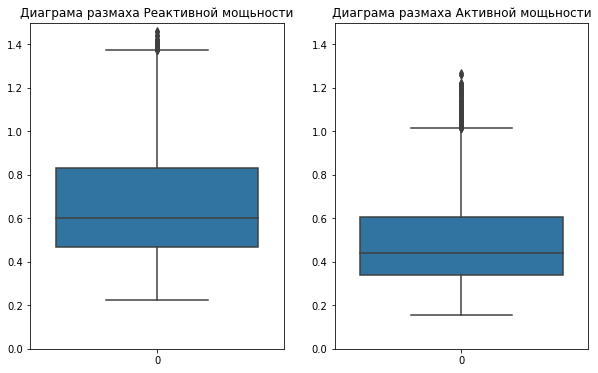

In [22]:
# Создание фигуры с двумя графиками
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10, 6])

# Создание диаграмм размаха для активной мощности
sns.boxplot(data=df_a['p_power'], ax=axes[0])
axes[0].set_title('Диаграма размаха Активной мощьности')
axes[0].set_ylim(0, 1.5)

# Создание диаграмм размаха для реактивной мощности
sns.boxplot(data=df_a['q_power'], ax=axes[1])
axes[1].set_title('Диаграма размаха Реактивной мощьности')
axes[1].set_ylim(0, 1.5)

plt.show()

#### Вывод: на графике видно, что есть некоторые выбросы.

(1500.0, 1700.0)

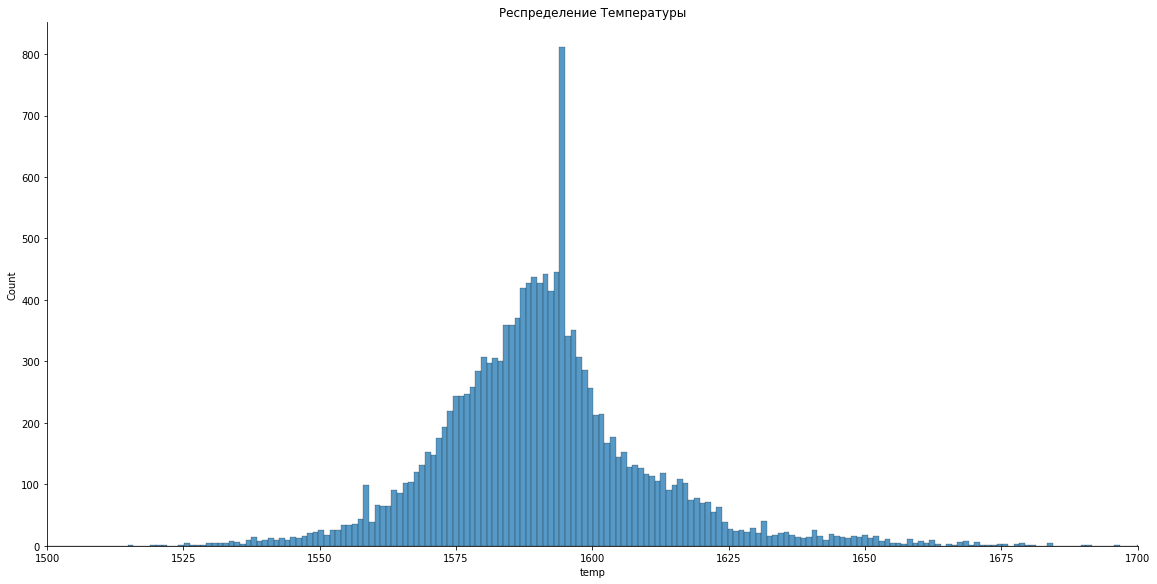

In [23]:
# Создание гистограммы распределения температуры
g = sns.displot(df_t['temp'], bins=500, height=8, aspect=2)
g.fig.suptitle("Распределение температуры", va='baseline')
plt.xlim(1500, 1700)

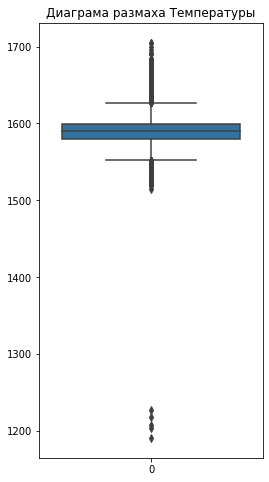

In [24]:
# Создание фигуры с размерами
plt.figure(figsize=[4, 8])

# Создание диаграммы размаха для температуры
sns.boxplot(data=df_t['temp'])
plt.title("Диаграмма размаха Температуры")
plt.show()

 #### Вывод: На графике целевой показатель, сейчас медиана находится около 1590 С. Задача бизнеса сместить медиану и среднее значение до 1450 С (температуры достаточной для плавления металла). В данных присутствуют вбросы.

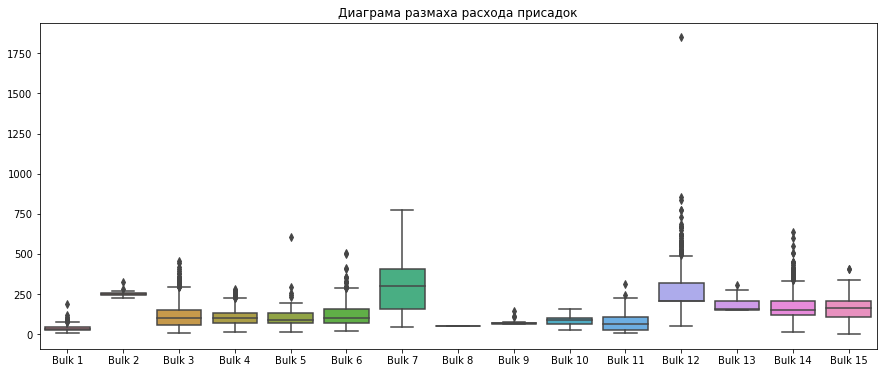

In [25]:
# Создание фигуры с размерами
plt.figure(figsize=[15, 6])

# Создание диаграмм размаха для расхода присадок
sns.boxplot(data=df_b.drop('key', axis = 1))
plt.title("Диаграмма размаха расхода присадок")
plt.show()

#### Вывод: На графике расход присадки, монжно наблюдать не равномерное распределение присадки по колличству. Вместо удаления совсем редких позиций, объединим их в одну большую. Тем самым не потеряем их важность.

(-3.89093352756, 81.89437171896)

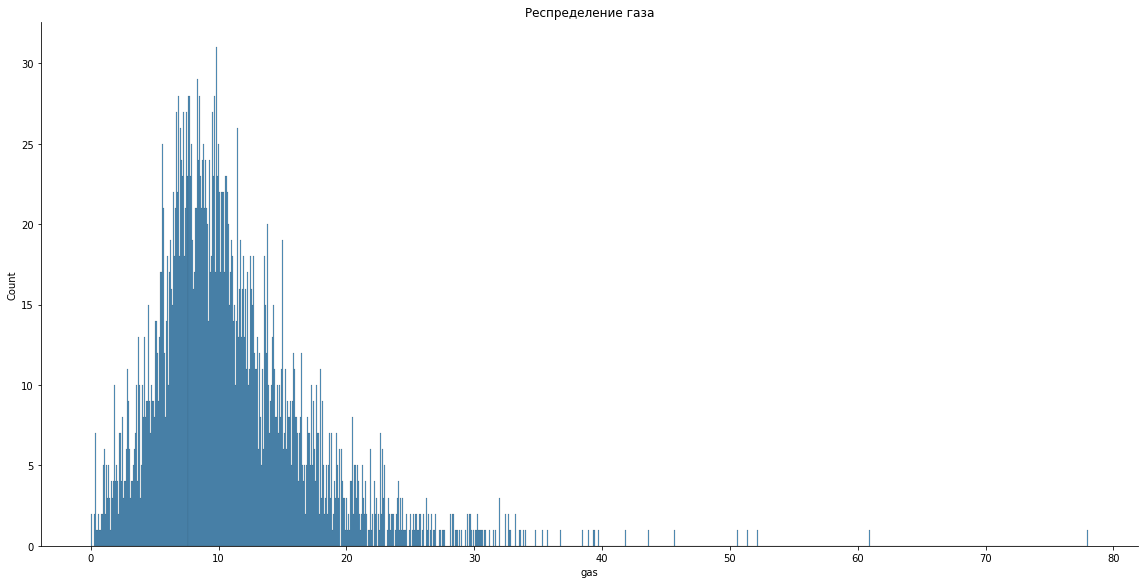

In [26]:
# Создание гистограммы распределения газа
sns.displot(df_g['gas'], bins = 1000, height=8, aspect=2)
plt.title("Респределение газа")
plt.xlim()

#### Вывод: На графике видим распределение расхода газа, распределение равномерное.

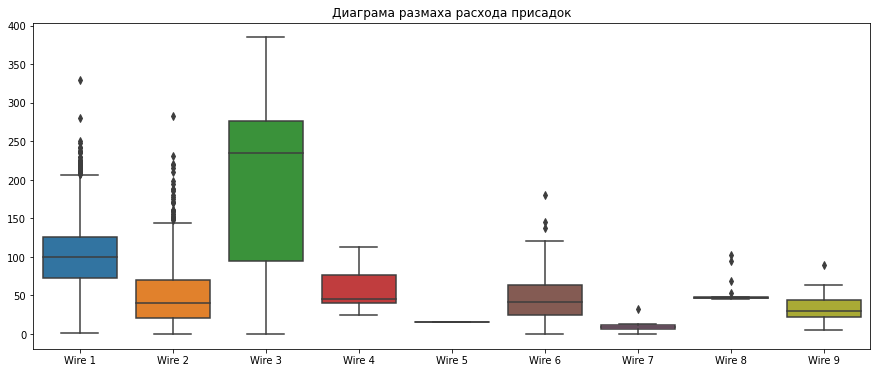

In [27]:
# Создание фигуры с размерами
plt.figure(figsize=[15, 6])

# Создание диаграмм размаха для расхода присадок
sns.boxplot(data=df_w.drop('key', axis = 1))
plt.title("Диаграмма размаха расхода присадок")
plt.ylim()
plt.show()

 #### Вывод: 
 - На графике расход проволочной присадки. Распределение похоже на друугие присадки, тем самым используем метод обработки такой же.

### Вывод: 
- Изучив данные можно создать новые факторы (Общая мощность, Время работы), так же необходими объеденить редкие факторы в присадках в один фактор, не меняя тип присадки. Так как задача на регрессию временые метки нам совсем не нужны.

# Предварительная обработка данных

### Обрадотка данных в датафрейме с мощностью нагревателей

In [28]:
# Фильтруем датафрейм оставляя только строки
# где значение столбца q_power больше 0, и перенумеровываем индексы
df_a = df_a[df_a['q_power'] > 0].reset_index(drop=True)

# Добавляем столбец s_power(Общая мощность) 
# вычисляя по формуле
df_a['s_power'] = np.sqrt(df_a['p_power']**2 + df_a['q_power']**2)

# Добавляем столбец time_h
# вычисляя разницу между end и start heating в секундах
df_a['time_h'] = df_a['end_heating'] - df_a['start_heating']

# Переводим секунды в часы
df_a['time_h'] = df_a['time_h'].astype('timedelta64[s]') / 3600

# Удаляем более не нужные столбцы
df_a = df_a.drop(['p_power', 'q_power', 'start_heating',
                  'end_heating'], axis=1)

# Группируем данные по столбцу key и суммируем значения
df_a = df_a.groupby('key').sum()

df_a.info()
df_a.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   s_power  3214 non-null   float64
 1   time_h   3214 non-null   float64
dtypes: float64(2)
memory usage: 75.3 KB


,s_power,time_h
key,,
1,3.718736,0.305000
2,2.588349,0.225278
3,5.019223,0.181944
4,3.400038,0.205833
5,2.816980,0.241389


### Обрадотка данных в датафрейме с температурой таргетом

In [29]:
# Удаление строк с пропущенными значениями
df_t = df_t.dropna()

# Удаление измерений с температурой менее 1400 градусов и переиндексация
df_t = df_t[df_t.temp >= 1400].reset_index(drop=True)

# Оставляем только те ключи, где измерений температуры больше двух
df_t = df_t.groupby('key').filter(lambda x: len(x) >= 2)

# Агрегация данных по ключу, взятие первой и последней температуры
df_t = df_t.groupby('key').agg(['first', 'last']).reset_index()

# Смена имён столбцов
df_t.columns = ['key', 'temp_first', 'temp_last']

# Установка индексации по ключам
df_t = df_t.set_index(['key'])

# Проверяем полученные изменения
df_t.info()
df_t.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_first  2475 non-null   float64
 1   temp_last   2475 non-null   float64
dtypes: float64(2)
memory usage: 58.0 KB


,temp_first,temp_last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


### Обрадотка данных в датафрейме с присадками булк

In [30]:
# Приведение имен столбцов к нижнему регистру
df_b.columns = df_b.columns.str.lower()

# Заполнение пропущенных значений 0
df_b = df_b.fillna(0)

# Объединение редко используемых присадок в один столбец
df_b['bulk_16'] = df_b.iloc[:, [1, 2, 5, 6, 7, 8, 9, 10, 11, 13]].sum(axis=1)

# Замена названий столбцов 
df_b = df_b.rename(columns={f'bulk {i}': f'bulk_{i}' for i in range(0, 16)})

# Оставление только нужных столбцов
df_b = df_b.iloc[:, [0, 3, 4, 12, 14, 15, 16]]

# Установка кей в качестве индекса
df_b = df_b.set_index(['key'])

df_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_3   3129 non-null   float64
 1   bulk_4   3129 non-null   float64
 2   bulk_12  3129 non-null   float64
 3   bulk_14  3129 non-null   float64
 4   bulk_15  3129 non-null   float64
 5   bulk_16  3129 non-null   float64
dtypes: float64(6)
memory usage: 171.1 KB


### Обрадотка данных в датафрейме с газом

In [31]:
# Установка кей в качестве индекса
df_g = df_g.set_index(['key'])

### Обрадотка данных в датафрейме с присадками типа проволка

In [32]:
# Приводим названия столбцов к нижнему регистру
df_w.columns = df_w.columns.str.lower()

# Заполняем пропущенные значения нулями
df_w = df_w.fillna(0)

# Объединение редко используемых присадок в один столбец
df_w['wire_10'] = df_w.iloc[:, [3, 4, 5, 6, 7, 8, 9,]].sum(axis=1)

# Замена названий столбцов 
df_w = df_w.rename(columns={f'wire {i}': f'wire_{i}' for i in range(0, 10)})

# Оставление только нужных столбцов
df_w = df_w.iloc[:, [0, 1, 2, 10]]

# Установка кей в качестве индекса
df_w = df_w.set_index(['key'])


df_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   wire_1   3081 non-null   float64
 1   wire_2   3081 non-null   float64
 2   wire_10  3081 non-null   float64
dtypes: float64(3)
memory usage: 96.3 KB


# Объединение в один датафрейм

In [33]:
# Записываем имена фреймов в переменную
dfs = [df_t, df_b, df_w, df_g, df_a]

# Объединяем датафреймы по индексам
df = pd.concat(dfs, axis=1)

# Удаляем исходные датафреймы, чтобы освободить память
del df_t, df_b, df_w, df_g, df_a

# Оставляем только те ключи, что были во всех датафреймах
df=df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_first  2329 non-null   float64
 1   temp_last   2329 non-null   float64
 2   bulk_3      2329 non-null   float64
 3   bulk_4      2329 non-null   float64
 4   bulk_12     2329 non-null   float64
 5   bulk_14     2329 non-null   float64
 6   bulk_15     2329 non-null   float64
 7   bulk_16     2329 non-null   float64
 8   wire_1      2329 non-null   float64
 9   wire_2      2329 non-null   float64
 10  wire_10     2329 non-null   float64
 11  gas         2329 non-null   float64
 12  s_power     2329 non-null   float64
 13  time_h      2329 non-null   float64
dtypes: float64(14)
memory usage: 272.9 KB


# Исследование объединённого датафрейма

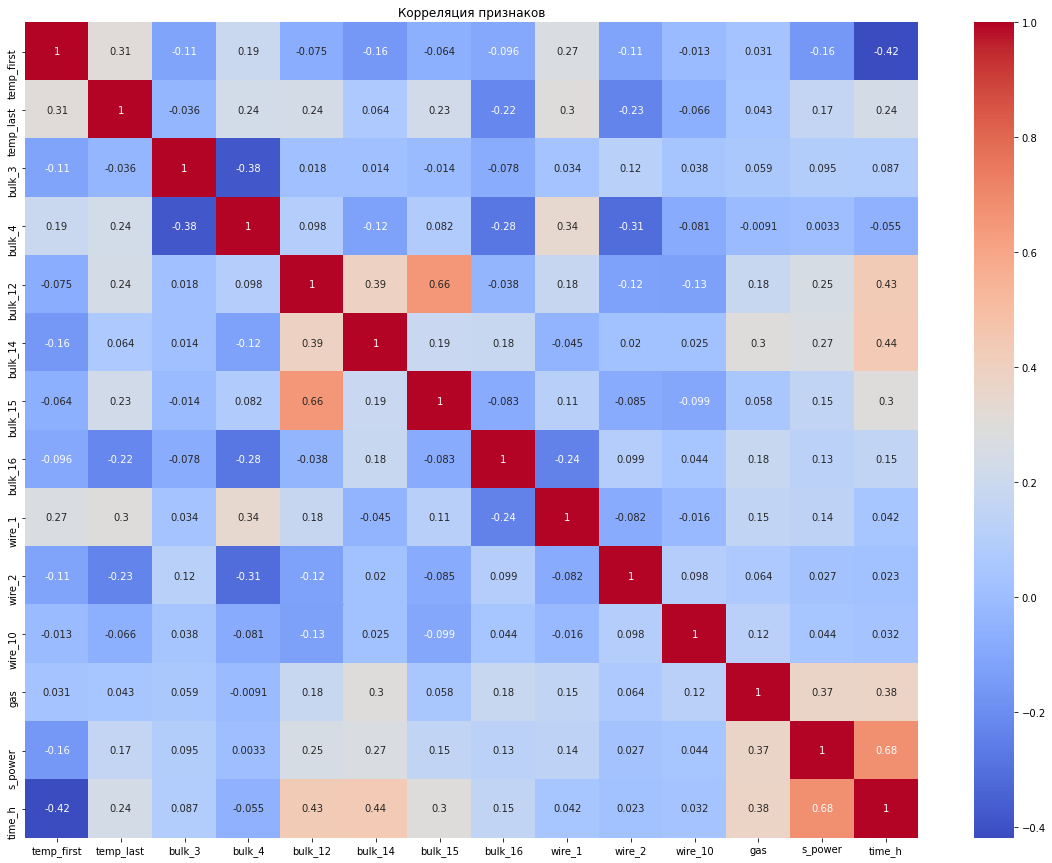

In [34]:
# Создание графика тепловой карты для визуализации корреляции между признаками
plt.figure(figsize=(20, 15))
plt.title('Корреляция признаков')
sns.heatmap(df.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

### Вывод: Явных зависимойстей более 0,7 в данных не наблюдется, там самым можно сказать, что это не должно повлиять на результаты. Однока если результаты будут не удовлетворительными, можно будет удалить два признака Булк 12 и Время работы.

In [35]:
df

,temp_first,temp_last,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,bulk_16,wire_1,wire_2,wire_10,gas,s_power,time_h
key,,,,,,,,,,,,,,
1,1571.0,1613.0,0.0,43.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986,3.718736,0.305000
2,1581.0,1602.0,0.0,73.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561,2.588349,0.225278
3,1596.0,1599.0,0.0,34.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793,5.019223,0.181944
4,1601.0,1625.0,0.0,81.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219,3.400038,0.205833
5,1576.0,1602.0,0.0,78.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692,2.816980,0.241389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,21.0,0.0,256.0,129.0,223.0,90.0,89.150879,0.00000,0.0,7.125735,3.868721,0.200833
2496,1554.0,1591.0,0.0,63.0,256.0,129.0,226.0,122.0,114.179527,0.00000,0.0,9.412616,5.070316,0.261111
2497,1571.0,1589.0,0.0,85.0,230.0,124.0,226.0,0.0,94.086723,9.04800,0.0,6.271699,4.360918,0.158056


# Предобработка для моделей

<font size="3"><b>Определяем признаки и таргет в переменные.</b></font>

In [35]:
# Объявлеяем таргет 
y = df.temp_last

# Объявляем признаки 
X = df.drop(['temp_last'], axis = 1)

<font size="3"><b>Делим данные на выборки 75/25 %</b></font>

In [36]:
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.25, 
                                                    random_state=12345)

<font size="3"><b>Проверяем средний таргет после деления на выборки.</b></font>

In [37]:
round(y_train.mean(),2), round(y_test.mean(), 2), round(y.mean(), 2)

(1593.49, 1593.0, 1593.37)

<font size="3"><b>Стандартизируем признаки моделью StandardScaler</b></font>

In [38]:
# отключает предупреждения Pandas
pd.options.mode.chained_assignment = None

# создает объект класса StandardScaler
scaler = StandardScaler()

# применяем метод fit к набору данных X_train
# чтобы вычислить параметры среднего и стандартного отклонения
scaler.fit(X_train)

# стандартизируем признаки
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)


X_train

array([[ 0.70549014, -0.61741725, -0.63630533, ..., -0.90121768,
        -1.69354501, -1.34583441],
       [-0.52379468, -0.61741725, -0.63630533, ..., -0.40527116,
         0.31184103, -0.12518179],
       [-0.65096208, -0.61741725, -0.63630533, ..., -0.29785683,
         0.43490684, -0.07223782],
       ...,
       [ 0.02726403, -0.61741725,  0.96062683, ..., -0.63213174,
        -0.08339252, -0.58108819],
       [ 1.55327277,  0.90473986, -0.63630533, ..., -0.08484139,
         0.97503732, -0.32225101],
       [-0.8205186 , -0.61741725, -0.63630533, ...,  0.69986432,
        -0.59629311,  0.31013528]])

# Обучение моделей

<font size="3"><b>Модель LinearRegression с базовыми параметрами.</b></font>

In [39]:
%%time

# Создаем объект модели линейной регрессии
lr = LinearRegression()

# Оценка качества модели с помощью кросс-валидации
scores = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=5)*-1

# Обучение модели на тренировочных данных
lr.fit(X_train, y_train)

# Прогнозирование целевой переменной на тестовых данных
y_pred = lr.predict(X_test)

# Оценка качества модели на тестовых данных
mae_lr_0 = mean_absolute_error(y_test, y_pred)

# Расчет среднего значения MAE на кросс-валидации
mae_lr = scores.mean()

# Выводим результаты оценки
print(f"Среднее значение MAE на кросс-валидации: {mae_lr}")
print(f"MAE на тестовых данных: {mae_lr_0}")

CPU times: total: 0 ns
Wall time: 62.9 ms


(6.375222060838563, 6.3664167257221935)

<font size="3"><b>Модель RandomForestRegressor с базовыми параметрами.</b></font>

In [40]:
%%time

# Создаем объект случайного леса
rfr = RandomForestRegressor(random_state = 240423)

# Оценка качества модели с помощью кросс-валидации
scores = cross_val_score(rfr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=5)*-1

# Обучаем модель случайного леса на тренировочном наборе данных
rfr.fit(X_train, y_train)

# Прогнозирование целевой переменной на тестовых данных
y_pred = rfr.predict(X_test)

# Оценка качества модели на тестовых данных
mae_rfr_0 = mean_absolute_error(y_test, y_pred)

# Рассчитываем среднюю абсолютную ошибку с помощью кросс-валидации
mae_rfr = scores.mean()

# Выводим результаты оценки
print(f"Среднее значение MAE на кросс-валидации: {mae_rfr}")
print(f"MAE на тестовых данных: {mae_rfr_0}")

CPU times: total: 14.6 s
Wall time: 15.6 s


(6.316375554645927, 6.552813036020583)

<font size="3"><b>Поиск лучших параметров для модели RandomForestRegressor, методом случайного подбора параметров.</b></font>

In [53]:
%%time

# Создаем объект модели случайного леса
rfr = RandomForestRegressor(random_state=240423, n_jobs=-1)

# Определяем диапазоны значений гиперпараметров для случайного поиска
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 100)]
max_depth = [int(x) for x in np.linspace(start = 5, stop = 20, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(start = 5, stop = 20, num = 15)]

# Определяем набор возможных значений гиперпараметров для случайного поиска
param_dist = {'max_depth': max_depth,
              'n_estimators': n_estimators,
              'min_samples_leaf': min_samples_leaf}

# Применяем случайный поиск
rs = RandomizedSearchCV(rfr, 
                        param_dist, 
                        n_iter = 30, 
                        cv = 5, 
                        verbose = 10, 
                        n_jobs=-1,
                        scoring = 'neg_mean_absolute_error',
                        random_state=240423)

# Обучаем модель случайного леса на тренировочном наборе данных
rs.fit(X_train, y_train)

# Предсказываем результаты на тренировочном датасете с помощью лучших найденных гиперпараметров
y_pred = rs.predict(X_test)

# Оценка качества модели на тестовых данных
mae_rs_0 = mean_absolute_error(y_test, y_pred)

# лучшее значение метрики случайным поиском
ran_for_rs = rs.best_score_*-1

# Выводим результаты оценки
print(f"Лучшее значение MAE случайным поиском: {ran_for_rs}")
print(f"MAE на тестовых данных: {mae_rs_0}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CPU times: total: 938 ms
Wall time: 33.4 s


(6.278489462859661, 6.626598016351513)

<font size="3"><b>Модель CatBoostRegressor с базовыми настройками.</b> </font>

In [42]:
%%time
# Создание объекта CatBoostRegressor
cat_reg = CatBoostRegressor(iterations=100, depth=5, verbose = False)

# Оценка качества модели с помощью кросс-валидации
scores = cross_val_score(cat_reg, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=5)*-1

# Создание обучающей выборки для CatBoostRegressor
train_pool = Pool(X_train, y_train)

# Обучение модели на обучающей выборке
cat_reg.fit(train_pool)

# Получение предсказаний на тестовой выборке
y_pred = cat_reg.predict(X_test)

# Оценка качества модели на тестовых данных
mae_cat_0 = mean_absolute_error(y_test, y_pred)

# Вычисление средней оценки MAE
mae_cat = scores.mean()

# Выводим результаты оценки
print(f"Лучшее значение MAE на кросс-валидации: {mae_cat}")
print(f"MAE на тестовых данных: {mae_cat_0}")

CPU times: total: 1.39 s
Wall time: 2.15 s


(6.214805309171057, 6.605917758370775)

<font size="3"><b>Проверяем базовые параметры модели LGBMRegressor.</b></font>

In [43]:
%%time
# Создание экземпляра LGBMRegressor
lgb = LGBMRegressor(objective='regression', metric = 'mae', random_state=240423)

# Оценка качества модели с помощью кросс-валидации
scores = cross_val_score(lgb, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=5)*-1

# Обучение модели LGBMRegressor
lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,  eval_metric='mae')

# Предсказание на тестовом датасете
y_pred = lgb.predict(X_test)

# Оценка качества модели на тестовых данных
mae_lgb_0 = mean_absolute_error(y_test, y_pred)

# Рассчитываем среднюю абсолютную ошибку с помощью кросс-валидации
mae_lgb = scores.mean()

# Выводим результаты оценки
print(f"Лучшее значение MAE на кросс-валидации: {mae_lgb}")
print(f"MAE на тестовых данных: {mae_lgb_0}")

[1]	valid_0's l1: 8.13813
[2]	valid_0's l1: 7.94534
[3]	valid_0's l1: 7.76754
[4]	valid_0's l1: 7.63189
[5]	valid_0's l1: 7.50697
[6]	valid_0's l1: 7.39645
[7]	valid_0's l1: 7.29322
[8]	valid_0's l1: 7.19729
[9]	valid_0's l1: 7.0959
[10]	valid_0's l1: 7.02939
[11]	valid_0's l1: 6.98325
[12]	valid_0's l1: 6.94187
[13]	valid_0's l1: 6.89999
[14]	valid_0's l1: 6.85259
[15]	valid_0's l1: 6.83361
[16]	valid_0's l1: 6.79839
[17]	valid_0's l1: 6.78822
[18]	valid_0's l1: 6.75341
[19]	valid_0's l1: 6.72833
[20]	valid_0's l1: 6.71759
[21]	valid_0's l1: 6.70766
[22]	valid_0's l1: 6.6781
[23]	valid_0's l1: 6.66774
[24]	valid_0's l1: 6.65646
[25]	valid_0's l1: 6.64776
[26]	valid_0's l1: 6.63958
[27]	valid_0's l1: 6.63101
[28]	valid_0's l1: 6.61684
[29]	valid_0's l1: 6.61354
[30]	valid_0's l1: 6.6027
[31]	valid_0's l1: 6.60954
[32]	valid_0's l1: 6.60216
[33]	valid_0's l1: 6.60004
[34]	valid_0's l1: 6.60135
[35]	valid_0's l1: 6.59487
[36]	valid_0's l1: 6.59309
[37]	valid_0's l1: 6.5937
[38]	valid_0's

C:\Users\Мария\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


(6.4050353670499005, 6.584791884728227)

<font size="3"><b>Сетка выбора параметров для модели LGBMRegressor.</b></font>

In [52]:
%%time

# Определяем диапазоны значений гиперпараметров для случайного поиска
parameters = {
    'max_depth': [-1, 3, 5, 6, 7, 9, 12, 15, 20, 25, 30, 35],
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'min_split_gain':[0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1],
    'n_estimators': [100, 300, 500],
    'reg_alpha': [0, 0.001, 0.01, 1],
    'reg_lambda': [0, 0.01, 0.05, 1]}

# Создание экземпляра LGBMRegressor
lgb = LGBMRegressor(objective='regression', random_state=240423)

# Применяем случайный поиск
lgb_random = RandomizedSearchCV(lgb,
                                parameters, 
                                n_iter = 20, 
                                cv = 3, 
                                verbose = 10, 
                                n_jobs=-1,
                                scoring = 'neg_mean_absolute_error',
                                random_state=240423)

# Обучение модели
lgb_random.fit(X_train, y_train)

# Предсказание на тестовом датасете
y_pred = lgb_random.predict(X_test)

# Оценка качества модели на тестовых данных
mae_lgb_1 = mean_absolute_error(y_test, y_pred)

# лучшее значение метрики случайным поиском
lgbm_score = lgb_random.best_score_*-1

# Выводим результаты оценки
print(f"Лучшее значение MAE случайным поиском: {lgbm_score}")
print(f"MAE на тестовых данных: {mae_lgb_1}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
CPU times: total: 2.58 s
Wall time: 5 s


(6.329570939728253, 6.6062764017347835)

## Анализ моделей

In [45]:
# Создание экземпляра констаннстной модели
const = DummyRegressor(strategy="mean")

# Обучение модели
const.fit(X_train, y_train)

# Предсказание на тренировочном датасете
pred_const = const.predict(X_train)

# Предсказание на тестовых датасете
pred_const_1 = const.predict(X_test)

# Оценка качества модели на тренировочных данных
mae_const = mean_absolute_error(y_train, pred_const)

# Оценка качества модели на тестовых данных
mae_const_1 = mean_absolute_error(y_test, pred_const_1)

# Выводим результаты оценки
print(f"Значение MAE констаннстной модели: {mae_const}")
print(f"MAE на тестовых данных констаннстной модели: {mae_const_1}")

(7.995414162169403, 8.396983843492315)

<font size="3"><b>Объединяем полученные результаты в одну таблицу для нагялдности</b></font>

In [54]:
mae_train = [round(mae_lr, 2),
             round(mae_rfr, 2),
             round(ran_for_rs, 2),
             round(mae_cat, 2),
             round(mae_lgb, 2),
             round(lgbm_score, 2), 
             round(mae_const, 2)]

data = {'mae_train' : mae_train}
        

total = pd.DataFrame(data, index=[
    'LinearRegression',
    'RandomForestRegressor_default',
    'RFR_RandomizedSearchCV',
    'CatBoostRegressor',
    'LGBMRegressor_default',
    'LGBMRegressor',
    'DummyRegressor'
])

total.sort_values('mae_train')

,mae_train
CatBoostRegressor,6.21
RFR_RandomizedSearchCV,6.28
RandomForestRegressor_default,6.32
LGBMRegressor,6.33
LinearRegression,6.38
LGBMRegressor_default,6.41
DummyRegressor,8.00


## Тестирование лучшей модели

In [57]:
print('Предварительный результат МАЕ на тестовой выборке: ',mae_cat_0.round(3))

Предварительный результат МАЕ на тестовой выборке:  6.606


### Вывод: исходя из данных полученных метрик, выбираем модель CatBoostRegressor.

### Определяем важность признаков в выборке

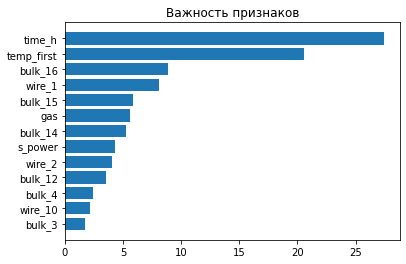

In [65]:
# Извлекаем важжность при знаков из обученной модели
importances = cat_reg.feature_importances_

# Создаем датафрейм с важностью признаков
X_results = pd.DataFrame({'feature': list(X.columns),
                          'importance': importances}).sort_values('importance')

# Устанавливаем заголовок
plt.title('Важность признаков')

# Строим горизонтальную столбчатую диаграмму
plt.barh(X_results['feature'], X_results['importance'])

# Отображаем график
plt.show()

In [66]:
# Удаляем менее значимые признаки
X_test_t = np.delete(X_test, [9, 2, 1], axis=1)
X_train_t = np.delete(X_train, [9, 2, 1], axis=1)

# Обучение модели
cat_reg.fit(X_train_t, y_train)

# Предсказание на тестовом датасете
X_pred = cat_reg.predict(X_test_t)

# Оценка качества модели на тестовых данных
best_mae = mean_absolute_error(y_test, X_pred)

print('Итоговое значение метрики МАЕ: ',best_mae.round(3))

Итоговое значение метрики МАЕ:  6.217


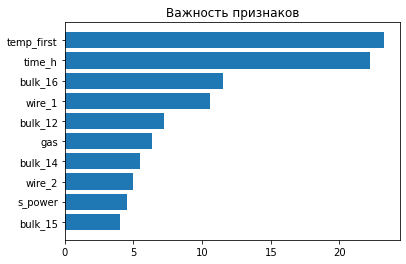

In [71]:
# Извлекаем важжность признаков из обученной модели
importances = cat_reg.feature_importances_

# Создаем датафрейм с важностью признаков
X_results = pd.DataFrame({'feature': list(X.columns.drop(X.iloc[:,[9,2,1]])),
                          'importance': importances}).sort_values('importance')

# Устанавливаем заголовок
plt.title('Важность признаков')

# Строим горизонтальную столбчатую диаграмму
plt.barh(X_results['feature'], X_results['importance'])

# Отображаем график
plt.show()

### Вывод: Смогли незначительно улучшить качество модели на 0,4. Методом удаления менее значимых признаков.

# Отчет

#### Выполненые пункты.
###### Часть 1: первичный анализ данных. Все пункты в разделе выполнены
- [x]  План работ по всему проекту.
- [x]  Изучить данные и обнаружить особенности в данных (выбросы/пропуски/нормальность распределения/)  
- [x]  Составить графический анализ данных
- [x]  Использование методов заполнения пропусков выявленных в данных  
- [x]  Объединение данных в один фрейм  
- [x]  Определение таргета и факторов  
###### Часть 2: построение самой модели. Все пункты в разделе выполнены 
- [x]  Поиск лучшей модели для данной задачи  
- [x]  Использование подбора гиперпараметров  
- [x]  Поиск важных факторов для таргета улучшение модели

### Сложности и решения :  
- В работе над проектом, возникали вопросы на тему определения таргета и его фильтрации. Этот вопрос был поднят на встречи с тим лидом, и подробно изучен. Выснили что самим таргетом является температура, а точнее послежнее ее вхождение.  

### Ключевые шаги:  
- В данном пректе важным и ключевым шагом была предобработка данных, а точнее создание новых факторов которые сильно повлияли на кацество предсказаний модели (изходя из данных о важности факторов).  

### Итоговая модель:  
- CatBoostRegressor Итоговое МАЕ = 6.217  

### Список признаков:  
- Время работы нагревателей
- Общая мощность
- Расход газа
- Сыпучая присадка 6 шт
- Проволочная присадка 3 шт
- Температура первый замер  
### Предобработка признаков: 
- Ключ: в данных по температуре, времени работы, присадки,ключи были разделены на итерации, и итераций всегда было разное количество, так как у нас была задача регрессии мы суммировали, а где то объеденили данные по ключам, в следствии ключи стали индексами в итоговой выборке.
- Время работы нагревателей: в данных были известны точная дата и время начала и конца нагрева, разница этих показателей стала одним параметром Временем работы.  
- Общая мощность: в днных были значения Активной и Реактивной мощьности, по формуле проебразовал их в однин параметр, так же в данных были вбросы слишком большие значения, которые мы убрали. 
- Расход газа: в данных небыло проблем они были с вбросами которые скорее всего реальные данные.  
- Сыпучая присадка: в данных было 15 видов присадки, не все из них часто использовались и были редкими их значения, что бы не терять это данные как параметр объеденили редко использованные присадки в одну группу, тем самым получили новый фактор в котором меньше шума и больше информативности.  
- Проволочная присадка: произведена работа аналогично сыпучей присадке, проблематика была та же.  
- Температура первый замер: в данных по температуре было много промежуточных замеров, при каждой итерации, добавления присадки либо размешивания, так же были ключи в которых был всего один замер температуры их мы исключили как не информативные. И тоговой выборке остались только те ключи, где замеров температуры было больше или равно двум. Тем самым первый замер стал признаком, второй таргетом.  
### Гипер параметры модели: CatBoostRegressor  
- iterations=100
- verbose = False
- max_depth=5
- random_state=240423
### Рекомендаций к улучшению модели:  
- Для улучшения модели можно попрбовать увеличить выборку и перемешать ее. Возможно метрика может еще улучшится.